In [1]:
from utils import load_dataset
import torch
from datetime import datetime
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

In [2]:
torch.manual_seed(123)
torch.set_default_dtype(torch.double)

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

### 3.1.1 ###
Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test. Take a subset of these datasets by keeping only 2 labels: bird and plane.

In [4]:
cifar2_train, cifar2_val, cifar2_test = load_dataset(CIFAR10)

Files already downloaded and verified
Files already downloaded and verified
Dataset: <class 'torchvision.datasets.cifar.CIFAR10'>
Size of the train dataset:       , 45000
Size of the validation dataset:  , 5000
Size of the test dataset:        , 10000


### 3.1.2 ###
Write a MyMLP class that implements a MLP in PyTorch (so only fully connected layers) such
that:

    (a) The input dimension is 3072 (= 32*32*3) and the output dimension is 2 (for the 2
    classes).

    (b) The hidden layers have respectively 512, 128 and 32 hidden units.

    (c) All activation functions are ReLU. The last layer has no activation function since the
    cross-entropy loss already includes a softmax activation function.

In [5]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = torch.flatten(x,1)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = self.fc4(out)
        return out


### 3.1.3 ###
Write a train(n epochs, optimizer, model, loss fn, train loader) function that trains
model for n epochs epochs given an optimizer optimizer, a loss function loss fn and a dataloader train loader

In [6]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):

    device = (torch.device('cuda') if torch.cuda.is_available()
        else torch.device('cpu'))
    
    print(f"Training on device {device}.")

    n_batch = len(train_loader)
    n_batch_val = len(val_loader)
    
    # We'll store there the training loss for each epoch
    losses_train = []
    losses_val = []
    
    # Re-initialize gradients, just in case the model has been inappropriately 
    # manipulated before the training
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1): 
        # Set the network in training mode
        model.train()
        
        # Training loss for the current epoch
        loss_train = 0

        # Loop over our dataset (in batches the data loader creates for us)
        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)
            
            # Feed a batch into our model
            outputs = model(imgs)
            
            # Compute the loss we wish to minimize 
            # Note that by default, it is the mean loss that is computed
            # (so entire_batch_loss / batch_size)
            loss = loss_fn(outputs, labels) 
            
            
            # Perform the backward step. That is, compute the gradients of all parameters we want the network to learn
            loss.backward()
            
            # Update the model
            optimizer.step() 
            
            # Zero out gradients before the next round (or the end of training)
            optimizer.zero_grad() 

            # Update loss for this epoch
            # It is important to transform the loss to a number with .item()
            loss_train += loss.item()
            
        # Store current epoch loss. 
        losses_train.append(loss_train / n_batch)

        model.eval()

        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:

                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss_val += loss_fn(outputs, labels).item()

        losses_val.append(loss_val / n_batch_val)
        
        
        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train, losses_val

# XXX

In [7]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, val_loader, weight_decay=0, momentum=0):
    
    # Train on GPU if available
    device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
    
    n_batch = len(train_loader)
    n_batch_val = len(val_loader)
    
    # We'll store there the training loss for each epoch
    losses_train = []
    losses_val = []
    
    # Will be used when applying momentum
    velocities = {}
    
    
    # Re-initialize gradient just in case they have been inappropriately 
    # manipulated before the training
    model.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1):
        # Set the network in training mode
        model.train()
        
        # Training loss for current epoch
        loss_train = 0
        
        # Loop over our dataset (in batches the data loader creates for us)
        for imgs, labels in train_loader:
            
            imgs.to(device=device, dtype=torch.double)
            labels.to(device=device)
            
            # Feed a batch into the model
            outputs = model(imgs)
            
            # Compute the loss we want to minimize
            loss = loss_fn(outputs, labels)
            
            # Perform the backward step
            loss.backward()
            
            # Update the model
            with torch.no_grad():
                
                # Want to update the weights and biases
                for name, p in model.named_parameters():
                    grad = p.grad
                    
                    # L2 regularization
                    if weight_decay:
                        grad += weight_decay * p.data
                    
                    # Momentum
                    if momentum:
                        if name not in velocities:
                            # Want to store a tensor separate from the graph
                            buf = velocities[name] = torch.clone(grad).detach()
                        else:
                            buf = velocities[name]
                            buf.mul_(momentum).add_(grad)
                        grad = buf
                    
                    # Learning step
                    p.data -= grad * lr
                    
                # Zero out the gradients
                model.zero_grad()
            # Update the loss for this epoch
            # Need to use .item() to transform the loss into a number
            loss_train += loss.item()
            
        # Store current epoch loss
        losses_train.append(loss_train / n_batch)
        
        model.eval()

        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:

                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss_val += loss_fn(outputs, labels).item()

        losses_val.append(loss_val / n_batch_val)
        
        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
            
    return losses_train, losses_val

### 3.1.5 ###
Train 2 instances of MyMLP, one using train and the other using train manual update (use
the same parameter values for both models). Compare their respective training losses. To get
exactly the same results with both functions, see section 3.3.

Note: only done for train,since have not made train_manual_update

In [8]:
n_epochs = 10
batch_size = 128
lr = 1e-1
weight_decay = 1e-3
momentum = 0.9

torch.manual_seed(123)
model_train = MyMLP().to(device=device) 
torch.manual_seed(123)
model_manual_train = MyMLP().to(device=device) 

optimizer = optim.SGD(model_train.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)

In [12]:
losses_train, losses_val = train(n_epochs, optimizer, model_train, loss_fn, train_loader, val_loader)

Training on device cpu.
13:01:57.502863  |  Epoch 1  |  Training loss 0.274
13:02:02.908515  |  Epoch 5  |  Training loss 0.254
13:02:09.902017  |  Epoch 10  |  Training loss 0.235


In [13]:
manual_losses_train, manual_losses_val = train_manual_update(n_epochs, lr, model_manual_train, loss_fn, train_loader, val_loader, weight_decay, momentum)

13:02:11.584882  |  Epoch 1  |  Training loss 0.261
13:02:17.993060  |  Epoch 5  |  Training loss 0.247
13:02:26.272671  |  Epoch 10  |  Training loss 0.211


### 3.1.10 ###
Evaluate the best model and analyse its performance.

In [14]:
train_loader = torch.utils.data.DataLoader(cifar2_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    acc =  correct / total
    print("Accuracy: {:.2f}".format(acc))
    return acc

In [15]:
# We want to use these global parameters for all 4 models

batch_size = 256
n_epoch = 100
loss_fn = nn.CrossEntropyLoss()
seed = 256
train_loader = torch.utils.data.DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)

In [16]:
# Model 1
lr_1 = 0.01
mom_1 = 0
decay_1 = 0
torch.manual_seed(seed)
model_1 = MyMLP().to(device=device) 

manual_losses_train_m1, manual_losses_val_m1 = train_manual_update(n_epoch, lr_1, model_1, loss_fn, train_loader, val_loader, weight_decay=decay_1, momentum=mom_1)
compute_accuracy(model_1, train_loader)
compute_accuracy(model_1, val_loader)

13:02:27.286694  |  Epoch 1  |  Training loss 0.682
13:02:30.756807  |  Epoch 5  |  Training loss 0.563
13:02:34.707375  |  Epoch 10  |  Training loss 0.474
13:02:39.210107  |  Epoch 15  |  Training loss 0.429
13:02:43.141899  |  Epoch 20  |  Training loss 0.390
13:02:47.057343  |  Epoch 25  |  Training loss 0.356
13:02:50.832830  |  Epoch 30  |  Training loss 0.322
13:02:54.484994  |  Epoch 35  |  Training loss 0.289
13:02:58.422888  |  Epoch 40  |  Training loss 0.265
13:03:02.392464  |  Epoch 45  |  Training loss 0.255
13:03:06.277011  |  Epoch 50  |  Training loss 0.235
13:03:10.836861  |  Epoch 55  |  Training loss 0.249
13:03:14.842033  |  Epoch 60  |  Training loss 0.211
13:03:18.712968  |  Epoch 65  |  Training loss 0.161
13:03:23.030674  |  Epoch 70  |  Training loss 0.132
13:03:26.712204  |  Epoch 75  |  Training loss 0.143
13:03:30.346734  |  Epoch 80  |  Training loss 0.136
13:03:33.994284  |  Epoch 85  |  Training loss 0.078
13:03:38.023036  |  Epoch 90  |  Training loss 0

0.8494404883011191

In [17]:
# Model 2
lr_2 = 0.01
mom_2 = 0.0
decay_2 = 0.01
torch.manual_seed(seed)
model_2 = MyMLP().to(device=device) 

manual_losses_train_m2, manual_losses_val_m2 = train_manual_update(n_epoch, lr_2, model_2, loss_fn, train_loader, val_loader, weight_decay=decay_2, momentum=mom_2)
compute_accuracy(model_2, train_loader)
compute_accuracy(model_2, val_loader)

13:03:47.271141  |  Epoch 1  |  Training loss 0.682
13:03:50.806530  |  Epoch 5  |  Training loss 0.567
13:03:55.455477  |  Epoch 10  |  Training loss 0.480
13:04:00.110511  |  Epoch 15  |  Training loss 0.437
13:04:04.369292  |  Epoch 20  |  Training loss 0.401
13:04:08.912374  |  Epoch 25  |  Training loss 0.370
13:04:13.565005  |  Epoch 30  |  Training loss 0.340
13:04:18.921136  |  Epoch 35  |  Training loss 0.312
13:04:24.941824  |  Epoch 40  |  Training loss 0.284
13:04:30.360031  |  Epoch 45  |  Training loss 0.264
13:04:35.816301  |  Epoch 50  |  Training loss 0.256
13:04:42.091971  |  Epoch 55  |  Training loss 0.210
13:04:46.966618  |  Epoch 60  |  Training loss 0.220
13:04:52.111545  |  Epoch 65  |  Training loss 0.229
13:04:56.710541  |  Epoch 70  |  Training loss 0.188
13:05:00.769892  |  Epoch 75  |  Training loss 0.210
13:05:04.751273  |  Epoch 80  |  Training loss 0.182
13:05:09.000613  |  Epoch 85  |  Training loss 0.185
13:05:13.138583  |  Epoch 90  |  Training loss 0

0.8514750762970499

In [18]:
# Model 3
lr_3 = 0.01
mom_3 = 0.9
decay_3 = 0
torch.manual_seed(seed)
model_3 = MyMLP().to(device=device) 

manual_losses_train_m3, manual_losses_val_m3 = train_manual_update(n_epoch, lr_3, model_3, loss_fn, train_loader, val_loader, weight_decay=decay_3, momentum=mom_3)
compute_accuracy(model_3, train_loader)
compute_accuracy(model_3, val_loader)

13:05:22.388259  |  Epoch 1  |  Training loss 0.625
13:05:25.570077  |  Epoch 5  |  Training loss 0.361
13:05:29.521329  |  Epoch 10  |  Training loss 0.240
13:05:33.459215  |  Epoch 15  |  Training loss 0.131
13:05:37.812023  |  Epoch 20  |  Training loss 0.082
13:05:42.208635  |  Epoch 25  |  Training loss 0.087
13:05:46.357242  |  Epoch 30  |  Training loss 0.083
13:05:50.408941  |  Epoch 35  |  Training loss 0.068
13:05:54.498710  |  Epoch 40  |  Training loss 0.042
13:05:58.967875  |  Epoch 45  |  Training loss 0.038
13:06:03.215926  |  Epoch 50  |  Training loss 0.012
13:06:07.228263  |  Epoch 55  |  Training loss 0.004
13:06:11.850534  |  Epoch 60  |  Training loss 0.007
13:06:16.533056  |  Epoch 65  |  Training loss 0.005
13:06:21.547884  |  Epoch 70  |  Training loss 0.007
13:06:26.161711  |  Epoch 75  |  Training loss 0.006
13:06:31.032920  |  Epoch 80  |  Training loss 0.006
13:06:35.879029  |  Epoch 85  |  Training loss 0.007
13:06:40.913825  |  Epoch 90  |  Training loss 0

0.8565615462868769

In [19]:
# Model 4
lr_4 = 0.01
mom_4 = 0.9
decay_4 = 0.01
torch.manual_seed(seed)
model_4 = MyMLP().to(device=device) 

manual_losses_train_m4, manual_losses_val_m4 = train_manual_update(n_epoch, lr_4, model_4, loss_fn, train_loader, val_loader, weight_decay=decay_4, momentum=mom_4)
compute_accuracy(model_4, train_loader)
compute_accuracy(model_4, val_loader)

13:06:51.455085  |  Epoch 1  |  Training loss 0.627
13:06:55.219642  |  Epoch 5  |  Training loss 0.376
13:07:00.028943  |  Epoch 10  |  Training loss 0.261
13:07:04.946450  |  Epoch 15  |  Training loss 0.183
13:07:10.068551  |  Epoch 20  |  Training loss 0.129
13:07:14.644086  |  Epoch 25  |  Training loss 0.192
13:07:19.700934  |  Epoch 30  |  Training loss 0.182
13:07:25.321066  |  Epoch 35  |  Training loss 0.096
13:07:30.198050  |  Epoch 40  |  Training loss 0.179
13:07:35.319337  |  Epoch 45  |  Training loss 0.137
13:07:41.053275  |  Epoch 50  |  Training loss 0.129
13:07:46.305296  |  Epoch 55  |  Training loss 0.061
13:07:51.720513  |  Epoch 60  |  Training loss 0.083
13:07:56.829682  |  Epoch 65  |  Training loss 0.116
13:08:02.262796  |  Epoch 70  |  Training loss 0.152
13:08:06.951480  |  Epoch 75  |  Training loss 0.056
13:08:11.856649  |  Epoch 80  |  Training loss 0.049
13:08:16.453814  |  Epoch 85  |  Training loss 0.089
13:08:21.039440  |  Epoch 90  |  Training loss 0

0.8250254323499492

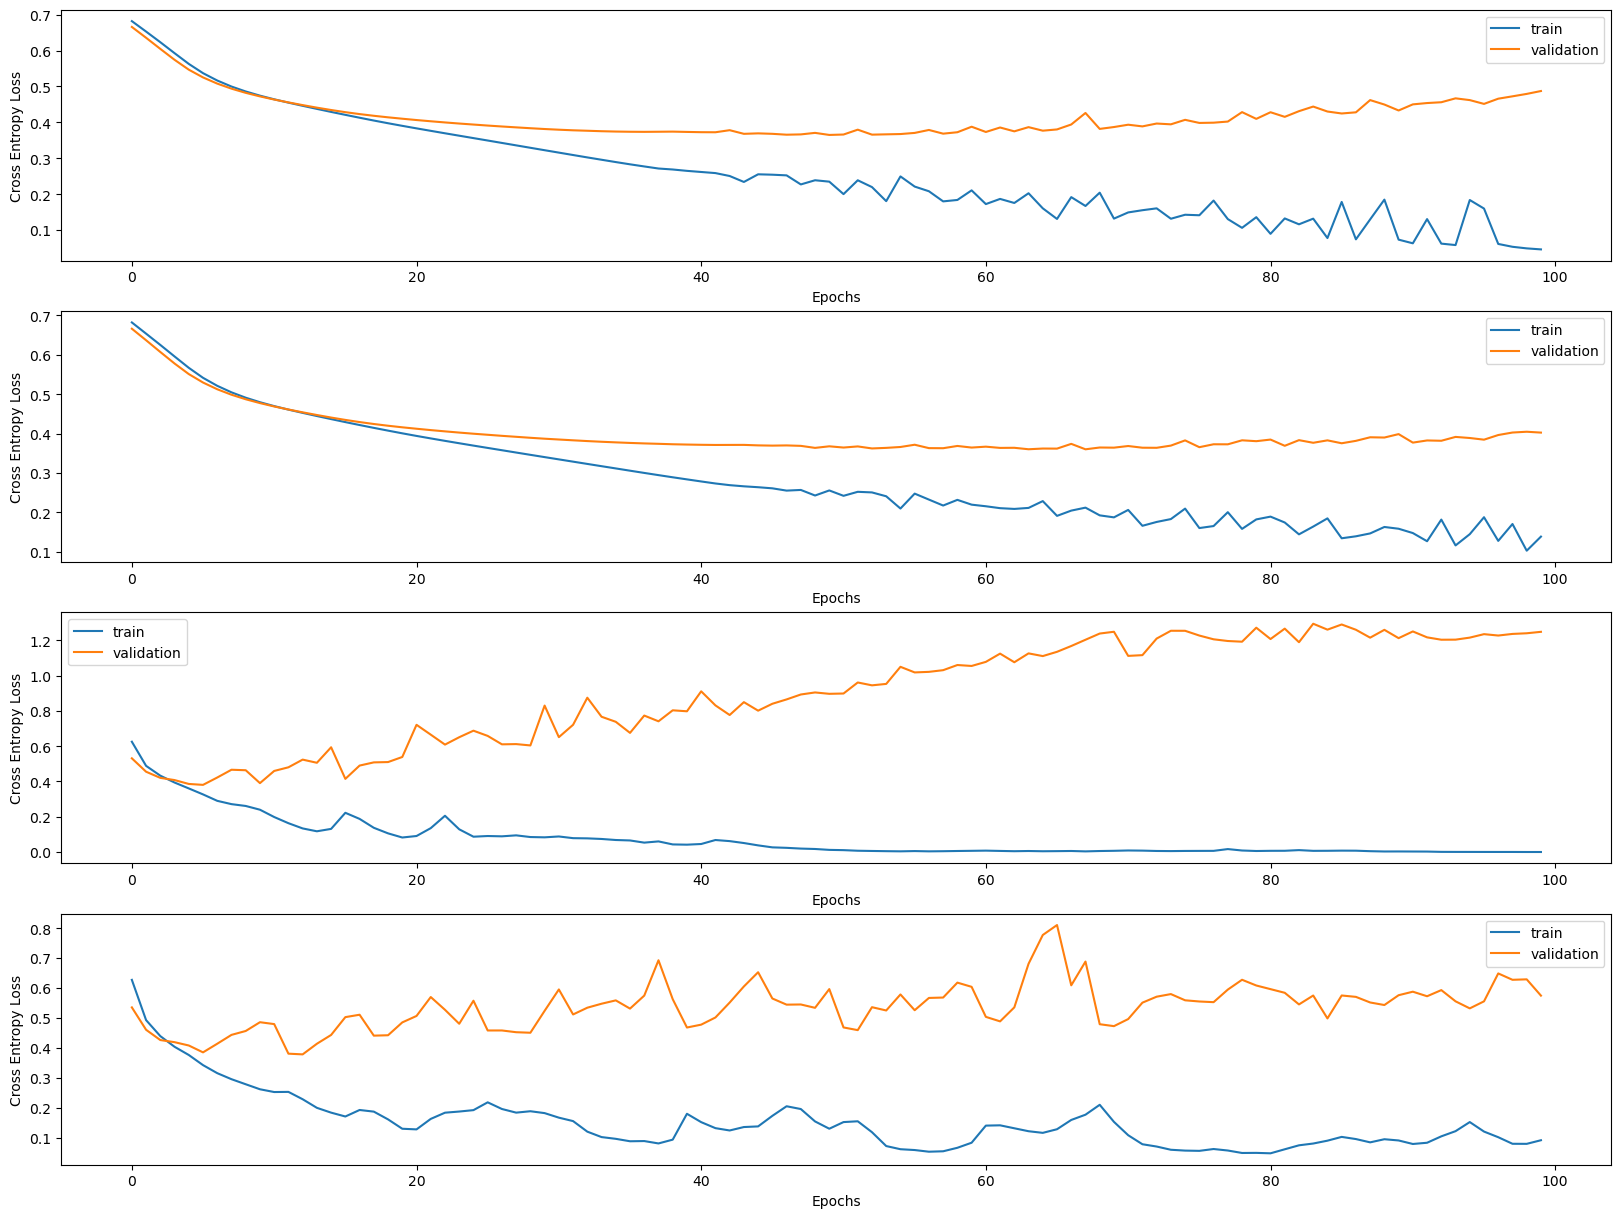

In [20]:
models = [(manual_losses_train_m1, manual_losses_val_m1),(manual_losses_train_m2, manual_losses_val_m2),(manual_losses_train_m3, manual_losses_val_m3),(manual_losses_train_m4, manual_losses_val_m4)]

fig, axes = plt.subplots(len(models), figsize=(20, 15))

for i, ax in enumerate(axes.flat):
    l_train, l_val = models[i]
    ax.plot(l_train, label='train')
    ax.plot(l_val, label='validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()

plt.show()